#### Much of this code is adapted from Professor David Stewart's (University of Iowa Dept. of Mathematics) base code: (see stewart_code.ipynb)

In [95]:
using LinearAlgebra
using Plots

## Optimal Fishing Effort

#### Minimization problem: 
$\quad$ $\min_u{g(\textbf{x}(T))}$ subject to $\frac{d\textbf{x}}{dt} = \textbf{F}(\textbf{x}(t), \textbf{u}(t))$, $x(0) = x_0$
#### where
$\quad$ $\textbf{F}(\textbf{x}(t), \textbf{u}(t)) = \begin{bmatrix} \alpha f(f_{max}-f)-\beta f u \\ \delta m + \beta f u \end{bmatrix} \;$ , $\beta = 1, f_{max}=f_{0}=1$


#### Where our objective function is 
$\quad$ $g(\begin{bmatrix} f \\ m\end{bmatrix}) = -m(T)$

#### And the gradient is 
$\quad$ $\nabla g(\begin{bmatrix} f \\ m\end{bmatrix}) = \begin{bmatrix} 0 \\ 1 \end{bmatrix}$

In [302]:
function F(t::Float64, xv::Vector{Float64}, u::Vector{Float64}, params::Dict{String,Real}, verbose=0)
    alpha = get(params, "alpha", 0.1)
    delta = get(params, "delta", 0.05)
    beta = get(params, "beta", 1.0)
    f_max = get(params, "f_max", 1.0)
    f, m = xv 
    dfdt = alpha * f * (f_max - f) - beta * f * u[1]
    dmdt = delta * m + beta * f * u[1]
    func = [dfdt, dmdt]
    return func
end

function g(xv,verbose=0)
    return xv[2]
end

function dg(xv::Vector{Float64}, verbose=0) 
    return [0.0, -1.0]
end

dg (generic function with 4 methods)

#### Derivative of $\textbf{F}$ with respect to $\textbf{u}$
$\quad$ $\nabla_{u} \textbf{F}(t, \textbf{x}, \textbf{u}) = \begin{bmatrix} -f \\ f \end{bmatrix}$

In [97]:
function dFdu(xvect::Vector{Float64},u::Vector{Float64},params::Dict{String,Real},verbose=0)
    f = xv[1]
    beta = get(params, "beta", 1.0)
    grad = [-beta * f, beta * f]
    return reshape(grad,2,1)
end

dFdu (generic function with 2 methods)

#### Derivative of $\textbf{F}$ with respect to $\textbf{x}$
$\quad$ $\nabla_{x} \textbf{F}(t, \textbf{x}, \textbf{u}) = \begin{bmatrix} \alpha -2 \alpha f - u  && 0  \\ u  && \delta \end{bmatrix}$

In [98]:
function dFdx(t::Float64, xv::Vector{Float64}, u::Vector{Float64}, params::Dict{String,Real}, verbose=0)
    f = xv[1]
    alpha = get(params, "alpha", 1.0)
    beta = get(params, "beta", 1.0)
    delta = get(params, "delta", 1.0)
    jacobian = [    -alpha * (1 - 2*f) + beta * u[1]    beta * f     ;  
                              beta * u[1]                 delta      ]
    return jacobian
end

dFdx (generic function with 2 methods)

#### Discretization via Euler's Method
$\quad$ $\textbf{x}_{k+1} = \textbf{x} + h\textbf{F}(\textbf{x}_{k},\textbf{u}_{k})$

This allows us to find $\textbf{x}(T)$ via a forward pass

In [299]:
function forwardstep(t0::Float64,xv::Vector{Float64},u::Matrix{Float64},F::Function,params::Dict{String,Real},verbose=0,n_eqs=2)
    N = size(u,n_eqs) # number of cols of u
    n = length(xv)
    xs = zeros(eltype(xv),n,N+1)
    xs[:,1] = xv
    h = get(params,"h",0.1)
    count = 0
    for i = 0:N-1
        if count == 0
            println("xs[:,i+1] shape: ", size(xs[:,i+1]))
        end
        count += 1
        xs[:,i+2] = xs[:,i+1] + h*F(t0+i*h,xs[:,i+1],u[:,i+1],params)
    end
    xs
end

forwardstep (generic function with 3 methods)

#### Lagrange Multiplier Equations
$\quad$ $\lambda_{k-1} = \lambda_{k} + h\nabla_{x} \textbf{F}(\textbf{x}_k, \textbf{u}_k)^T \lambda$

Moving backwards from the last $\lambda$ fills in the rest of the $\lambda$'s via a backward pass

In [244]:
# filling in the lagrange multipliers 
function adjointstep(λend::Vector{Float64},t0::Float64,xv::Matrix{Float64},u::Matrix{Float64},dFdx::Function,params::Dict{String,Real},verbose=0,n_eqs=2)
    N = size(u,n_eqs)
    n = length(λend)
    λs = zeros(eltype(λend),n,N)
    λs[:,N] = λend
    count = 0
    h = get(params,"h",0.1)
    for i = N-2:-1:0
        λs[:,i+1] = λs[:,i+2] + h*dFdx(t0+i*h,xv[:,i+1],u[:,i+1],params)'*λs[:,i+2]
    end
    λs
end

adjointstep (generic function with 3 methods)

#### Objective function
$\quad$ $g(\textbf{x}_N)=G(\textbf{u}_{0}, \textbf{u}_{1}, ... , \textbf{u}_{N-1})$

where $g(\textbf{x}_k)$ is the output at each step $k$

In [224]:
function G(t0::Float64,xv::Vector{Float64},u::Matrix{Float64},F::Function,g::Function,params::Dict{String,Real},verbose=0)
    xs = forwardstep(t0,xv,u,F,params)
    return g(xs[:,end])
end

G (generic function with 2 methods)

#### Gradient of objective function with respect to $\textbf{u}$
$\quad$ $\nabla_{u_{k}} g(\textbf{x}_{N}) = h\nabla_{u}\textbf{F}(\textbf{x}_{k}, \textbf{u}_{k})^T \lambda_{k}$

In [225]:
function dG(t0::Float64,xv::Vector{Float64},u::Matrix{Float64},F::Function,dFdx::Function,dFdu::Function,dg::Function,params,verbose=0)
    h = get(params, "h", 0.1)
    xs = forwardstep(t0,xv,u,F,params)
    λend = dg(xv[:,end])
    λs = adjointstep(λend,t0,xs,u,dFdx,params)
    dGval = zeros(eltype(u),size(u,1),size(u,2))
    for i = 0:size(u,2)-1
        dGval[:, i+1] = h*dFdu(xs[:, i+1],u[:,i+1],params)'*λs[:, i+1]
    end
    dGval
end

dG (generic function with 2 methods)

#### Projection of controls onto $\space \mathcal{U}$
$\quad$ Search direction: $\textbf{d}=[(\textbf{d}_{0})^T, (\textbf{d}_{2})^T, ... , (\textbf{d}_{N-1})^T]^T$\
$\quad$ New control: $\textbf{u}^{+}(\alpha) = Proj_{\mathcal{U}}(\textbf{u}+\alpha \textbf{d})$, $\space$ $\mathcal{U}$ convex

This is to incorporate the constraints $\textbf{u}_{k} \in U \space \forall k$

In [226]:
function proj_u(u,a,b)
    clamp.(u, a, b)
end

proj_u (generic function with 1 method)

#### Optimal Control Algorithm
Performs gradient descent in conjunction with backtracking line search on the iterates of $\textbf{u}$

In [227]:
function gradient_descent(u,s,dGval,proj)
    return proj(u-s*dGval)
end

gradient_descent (generic function with 1 method)

In [228]:
function optcontrol(t0::Float64,x0::Vector{Float64},u::Matrix{Float64},F::Function,dFdx::Function,dFdu::Function,g::Function,dg::Function,proj::Function,params::Dict{String,Real},ulist=nothing,trace=0)
    Gval = G(t0,x0,u,F,g,params,1)
    Gvalold = Gval
    dGval = dG(t0,x0,u,F,dFdx,dFdu,dg,params,1)
    firsttime = true
    iter = 0
    c1 = get(params, "c1", 0.01)
    s0 = get(params, "s0", 1.0)
    h = get(params, "h", 0.1)
    maxiter = get(params, "maxiter", 10000)
    eps = get(params, "eps", 0.4)
    if ulist != nothing
        push!(ulist,u)
    end
    while ( firsttime || (Gvalold - Gval > eps) ) && (iter < maxiter)
        Gvalold = Gval
        s = s0
        unew = gradient_descent(u,s,dGval,proj) # projected gradient descent
        Gval = G(t0,x0,unew,F,g,params,1)      
        count_linesearch=0
        while Gval > Gvalold + c1*dot(dGval,unew-u) && s > 1e-12*s0
            s = s / 2
            unew = gradient_descent(u,s,dGval,proj)
            Gval = G(t0,x0,unew,F,g,params,1)
            count_linesearch += 1
            if count_linesearch == 1
                break
            end
        end
        u = unew
        firsttime = false
        dGval = dG(t0,x0,u,F,dFdx,dFdu,dg,params,0)

        if ulist != nothing
            push!(ulist,u)
        end
        iter += 1
    end
    (u,iter)
end

optcontrol (generic function with 3 methods)

In [278]:
function optimize(xv,t,N,u,T,params,F,dFdx,dFdu,g,dg,n_eqs=2)
    println(typeof(u))
    println(typeof(xv))
    xs = forwardstep(t,xv,u,F,params,0,n_eqs)
    println("finished forward step")
    λend = dg(xs[:,end])
    println("computed λend")
    λs = adjointstep(λend,t,xs,u,dFdx,params,0,n_eqs)
    print("finished adjoint step")
    ulist = []
    u = fill(0.0, 1,N)
    opt_u,iters = optcontrol(t,xv,u,F,dFdx,dFdu,g,dg,u->proj_u(u,0.0,0.5),params,ulist,0)
    return opt_u, iters
end

optimize (generic function with 4 methods)

#### Initial Parameters #1:
$\quad$ $T = 20\space years, \alpha = 0.1/year, \delta = 0.05/year, u_{max}=0.5, N=200, h=0.1$

In [279]:
using LinearAlgebra
xv  = [0.9; 15.1]
t = 0.0; 
N = 200
u = zeros(1,N)
T = 20 

params = Dict(
    "alpha"=>0.1,
    "delta"=>0.05,
    "beta"=>1.0,
    "f_max"=>1.0,
    "h"=>0.1,
    "eps"=>1e-2,
    "s0"=>1.0, 
    "c1"=>0.05,
    "maxiter"=>10_000,
    "s"=>0.1
)

Dict{String, Real} with 10 entries:
  "eps"     => 0.01
  "c1"      => 0.05
  "s"       => 0.1
  "f_max"   => 1.0
  "maxiter" => 10000
  "alpha"   => 0.1
  "s0"      => 1.0
  "h"       => 0.1
  "delta"   => 0.05
  "beta"    => 1.0

In [280]:
opt_u, iters = optimize(xv,t,N,u,T,params,F,dFdx,dFdu,g,dg)

Matrix{Float64}
Vector{Float64}
finished forward step
computed λend
finished adjoint step

([0.12141121445952424 0.12080717856669079 … 0.045225 0.045000000000000005], 1)

In [281]:
opt_u

1×200 Matrix{Float64}:
 0.121411  0.120807  0.120206  0.119608  …  0.0454511  0.045225  0.045

In [303]:
xsopt = forwardstep(t,xv,opt_u,F,params)

xs[:,i+1] shape: (2,)


2×201 Matrix{Float64}:
 0.9  0.889973  0.880201   0.870675   …  0.470181  0.470546  0.47092
 0.0  0.010927  0.0217332  0.0324224     1.72895   1.73972   1.75054

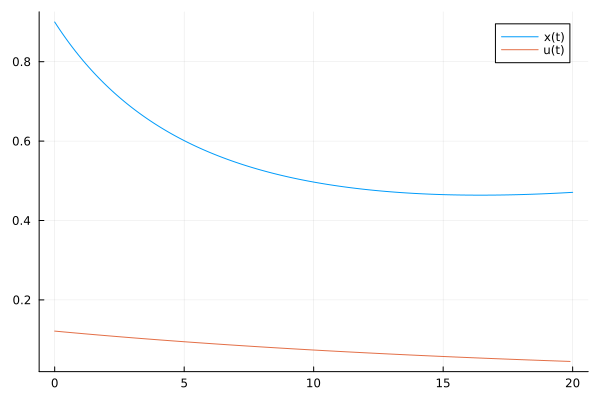

In [283]:
using Plots
plot(0.1*(0:N),xsopt[1,:],label="x(t)")
plot!(0.1*(0:N-1),opt_u[1,:],label="u(t)")

#### Initial Parameters #2:
$\quad$ $T = 20\space years, \alpha = 0.05/year, \delta = 0.1/year, u_{max}=0.5, N=200, h=0.1$

In [284]:
using LinearAlgebra
xv  = [0.9; 0.0]
t = 0.0; 
N = 200
u = zeros(1,N)
T = 20 

params = Dict(
    "alpha"=>0.1,
    "delta"=>0.05,
    "beta"=>1.0,
    "f_max"=>1.0,
    "h"=>0.1,
    "eps"=>1e-2,
    "s0"=>1.0, 
    "c1"=>0.05,
    "maxiter"=>10_000,
    "s"=>0.1
)

Dict{String, Real} with 10 entries:
  "eps"     => 0.01
  "c1"      => 0.05
  "s"       => 0.1
  "f_max"   => 1.0
  "maxiter" => 10000
  "alpha"   => 0.1
  "s0"      => 1.0
  "h"       => 0.1
  "delta"   => 0.05
  "beta"    => 1.0

In [285]:
opt_u, iters = optimize(xv,t,N,u,T,params,F,dFdx,dFdu,g,dg)

Matrix{Float64}
Vector{Float64}
finished forward step
computed λend
finished adjoint step

([0.12141121445952424 0.12080717856669079 … 0.045225 0.045000000000000005], 1)

In [286]:
xsopt = forwardstep(t,xv,opt_u,F,params)

2×201 Matrix{Float64}:
 0.9  0.889973  0.880201   0.870675   …  0.470181  0.470546  0.47092
 0.0  0.010927  0.0217332  0.0324224     1.72895   1.73972   1.75054

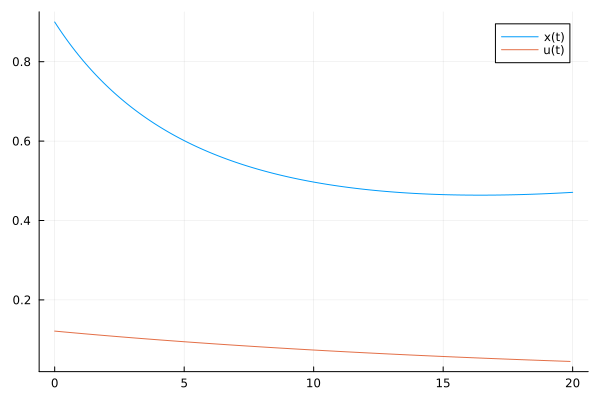

In [287]:
using Plots
plot(0.1*(0:N),xsopt[1,:],label="x(t)")
plot!(0.1*(0:N-1),opt_u[1,:],label="u(t)")

## Optimal Fishing Effort - Addition of Predator

#### Minimization problem: 
$\quad$ $\min_u{g(\textbf{x}(T))}$ subject to $\frac{d\textbf{x}}{dt} = \textbf{F}(\textbf{x}(t), \textbf{u}(t))$, $x(0) = x_0$
#### where
$\quad$ $\textbf{F}(\textbf{x}(t), \textbf{u}(t)) = \begin{bmatrix} \alpha f(f_{max}-f)-\beta f u - \gamma f s\\ \gamma f s - \rho s \\ \delta m + \beta f u\end{bmatrix} \;$ , $\beta = 1, f_{max}=f_{0}=1, \rho = 1, \alpha = 0.1, \gamma = 5$
#### So,
$\quad$ $\textbf{F}(\textbf{x}(t), \textbf{u}(t)) = \begin{bmatrix} \alpha f(1-f)-f u \\ \delta m + f u \end{bmatrix}, x(0)=x_{0}, \textbf{u}(t)\in U  \space \forall t$

#### Where our objective function is 
$\quad$ $g(\begin{bmatrix} f \\ m\end{bmatrix}) = -m(T)$

#### And the gradient is 
$\quad$ $\nabla g(\begin{bmatrix} f \\ m\end{bmatrix}) = \begin{bmatrix} 0 \\ -1 \end{bmatrix}$

In [288]:
function F_pred(t, x, u, params, verbose=0)
    f, s, m = x
    alpha = get(params,"alpha",0.1)
    delta = get(params,"delta",0.05)
    dfdt = alpha * f * (1 - f) - f* u[1] - 5 * f * s
    dsdt = 5 * f * s - s
    dmdt = delta * m + u[1] * f
    return [dfdt, dmdt]
end

function g_pred(xv,verbose=0)
    return -xv[2]
end

function dg_pred(xv, verbose=0) 
    return [0.0, -1.0]
end

function dFdu_pred(t, xvect,u,alpha,delta,verbose=0)
    return reshape([-xvect[1] ; xvect[1]],2,1)
end

function dFdx_pred(t, xv, u, alpha, delta,verbose=0)
    return [alpha - 2*alpha*xv[1] - u[1]  u[1];
                   0                    delta]
end

dFdx_pred (generic function with 2 methods)

In [304]:
xv2 = [1.0;1.0;1.0]
u2 = zeros(1,N)
optimize(xv2,t,N,u2,T,params,F_pred,dFdx,dFdu,g_pred,dg_pred,3)

Matrix{Float64}
Vector{Float64}
xs[:,i+1] shape: (3,)


LoadError: DimensionMismatch: dimensions must match: a has dims (Base.OneTo(3),), b has dims (Base.OneTo(2),), mismatch at 1